In [1]:
import pickle

import sys
sys.path.append('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/')
from model_and_circuit import *

from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [2]:
#Loading the original cat training data
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/target_distribution.pkl',"rb") as file1:
    cat_data = pickle.load(file1)
    
# Saving the AntiCat distribution
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/anticat_distribution.pkl',"rb") as file2:
    anticat_data = pickle.load(file2)

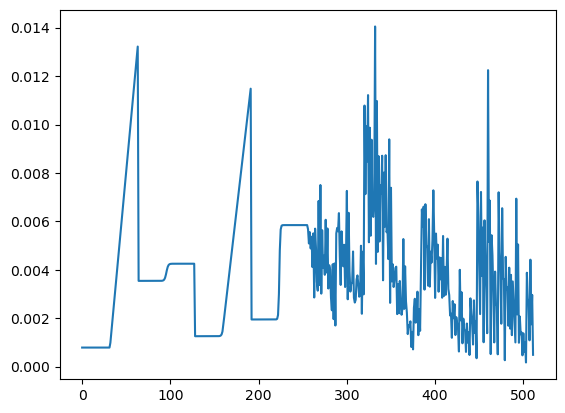

In [3]:
#Visualizing the Cat and AntiCat Distributions
id1 = jnp.array([1,0],dtype=jnp.float64)
id2 = jnp.array([0,1],dtype=jnp.float64)

full_cat_distribution = jnp.kron(id1,cat_data)
full_anticat_distribution = jnp.kron(id2,anticat_data)

cat_anticat_distribution = full_cat_distribution + full_anticat_distribution
x_full = jnp.arange(0,2**(n_qubits+1),dtype=jnp.float64)
plt.plot(x_full, cat_anticat_distribution, label='Cat-AntiCat Distribution')

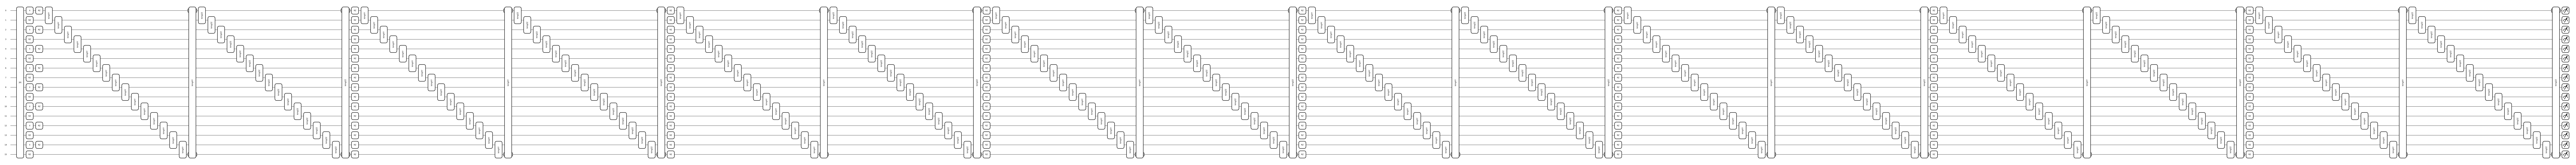

In [4]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [5]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd1,mmd2,py1,py2):
        self.circ = circ
        self.mmd1 = mmd1
        self.mmd2 = mmd2
        self.py1 = py1
        self.py2 = py2
    
    def mmd_loss(self,params):
        px = self.circ(params)
        loss1 = self.mmd1(px[0],self.py1)
        loss2 = self.mmd2(px[1],self.py2)
        
        return loss1+loss2, px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (total_loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs1 = jnp.asarray(qcbm_probs[0], dtype=jnp.float64)
    qcbm_probs2 = jnp.asarray(qcbm_probs[1], dtype=jnp.float64)
    
    kl_div1 = -jnp.sum(cat_data * jnp.nan_to_num(jnp.log(qcbm_probs1) - jnp.log(cat_data)))
    kl_div2 = -jnp.sum(anticat_data * jnp.nan_to_num(jnp.log(qcbm_probs2) - jnp.log(anticat_data)))
    
    total_kl_div = kl_div1 + kl_div2
    
    return params, opt_state, total_loss_val, total_kl_div

In [6]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd1 = MMD(bandwidth,space=space)
mmd2 = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd1,mmd2,py1=cat_data,py2=anticat_data)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.01,staircase=True)
# lr = 0.01
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0
# i = start_epoch

# while kl_div > 10^-3:
while i < 20001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)

Step: 10 Loss: 0.009242142550647259 KL_div:0.66558438539505 current_lr:0.10000000149011612 Time taken per iteration: 0.05440235137939453
Step: 20 Loss: 0.0023407158441841602 KL_div:0.2787821292877197 current_lr:0.10000000149011612 Time taken per iteration: 0.05455923080444336
Step: 30 Loss: 0.0010965637629851699 KL_div:0.2324816882610321 current_lr:0.10000000149011612 Time taken per iteration: 0.055577993392944336
Step: 40 Loss: 0.0006616327445954084 KL_div:0.15500187873840332 current_lr:0.10000000149011612 Time taken per iteration: 0.055670738220214844
Step: 50 Loss: 0.0004255046951584518 KL_div:0.11379170417785645 current_lr:0.10000000149011612 Time taken per iteration: 0.05359840393066406
Step: 60 Loss: 0.0003385866875760257 KL_div:0.094224713742733 current_lr:0.10000000149011612 Time taken per iteration: 0.0552220344543457
Step: 70 Loss: 0.00027403689455240965 KL_div:0.08164464682340622 current_lr:0.10000000149011612 Time taken per iteration: 0.055922508239746094
Step: 80 Loss: 0.0

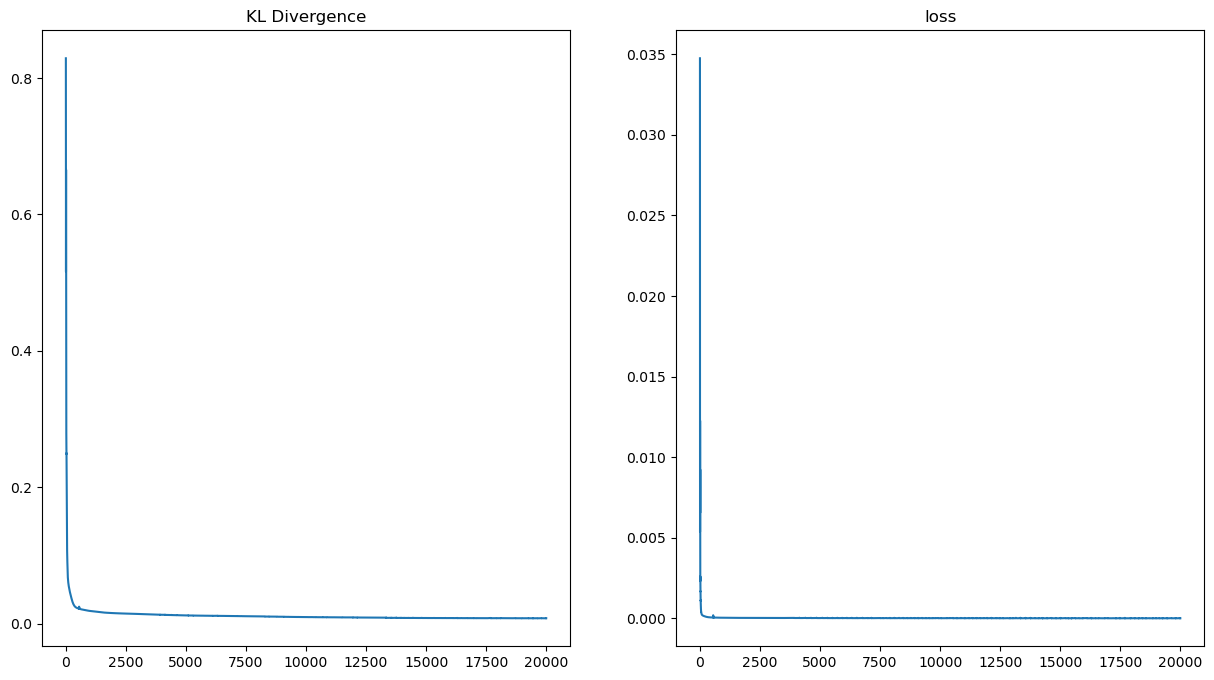

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

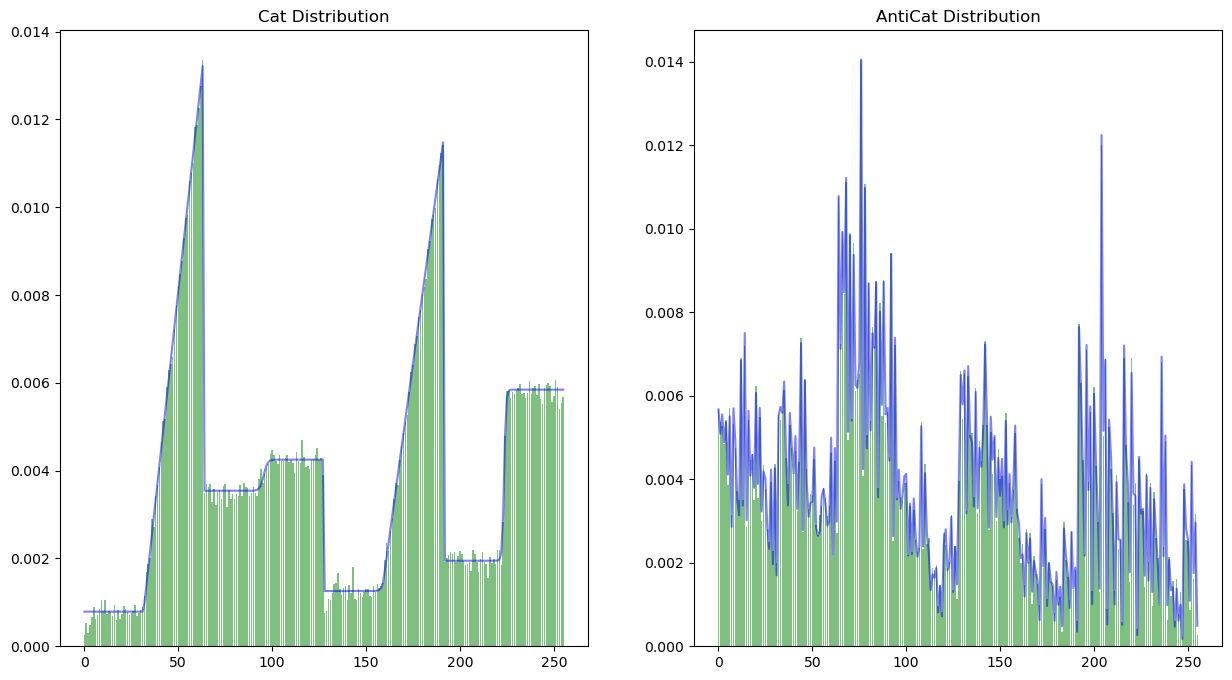

In [8]:
optimal_params = parameters[np.argmin(divs)]

qcbm_probs = circuit(optimal_params)
x_array = jnp.arange(0,2**(n_qubits),dtype=jnp.float64)

fig,axs = plt.subplots(1,2,figsize=(15,8))
axs[0].bar(x_array,qcbm_probs[0],color='green',alpha=0.5,label='Obtained Cat')
axs[0].plot(x_array,cat_data,color='blue',alpha=0.5,label='Original Cat')
axs[0].title.set_text('Cat Distribution')

axs[1].bar(x_array,qcbm_probs[1],color='green',alpha=0.5,label='AntiCat')
axs[1].plot(x_array,anticat_data,color='blue',alpha=0.5,label='Original AntiCat')
axs[1].title.set_text('AntiCat Distribution')

In [9]:
print(f"Minimum KL Divergence obtained is {np.min(divs)}")

Minimum KL Divergence obtained is 0.00774418655782938


In [10]:
#Save Checkpoint
checkpoint = {"final_epoch":i,
              "history":history,
              "divs":divs,
              "parameters":parameters}

with open(f'model_cat_anticat_distribution.pkl','wb') as file:
    pickle.dump(checkpoint,file)
    
print("Model saved successfully")

Model saved successfully
